# <h1><center> Customer Relationship Management (CRM) Analytics</center></h1>

## Introduction

Customer Relationship Management (CRM) system is an information management and analysis tool that can help businesses and other organizations manage their interactions with customers.

CRMs were originally designed to target large corporations, but the internet has allowed small business owners to take advantage of these tools as well. Customer data is collected in a CRM database, which allows for advanced analysis such as customer segmentation and contact history.

In this notebook, we will be explaining how you can apply your customer relationship management system to analyze your customer base in order to increase revenue through better marketing campaigns!

## Objective

An e-commerce company wants to segment its customers and determine marketing strategies according to these segments. For example, it is desired to organize different campaigns for new customers and different campaigns in order to retain customers that are very profitable for the company.

### Imporing Libraries

In [1]:
# installlation required
!pip install Lifetimes
!pip install openpyxl
# libraries
from sqlalchemy import create_engine
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
import squarify  # treemap 
import warnings 
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


### Load and Check Data

In [2]:
df_2010_2011 = pd.read_excel("C:/Users/MILAN/Downloads/archive (37)/online_retail_II.xlsx", sheet_name = "Year 2010-2011")

#online_retail = pd.read_csv("/kaggle/input/online-retail-ii-data-set-from-ml-repository/Year 2010-2011.csv", sep=";")
df = df_2010_2011.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# We deal with purchases in our analysis. Therefore, we have excluded returns from the data.
df = df[~df["Invoice"].str.contains("C", na=False)]
df.shape

(532622, 8)

### Data Preprocessing

In [4]:
def check_df(dataframe):
    print("################ Shape ####################")
    print(dataframe.shape)
    print("############### Columns ###################")
    print(dataframe.columns)
    print("############### Types #####################")
    print(dataframe.dtypes)
    print("############### Head ######################")
    print(dataframe.head())
    print("############### Tail ######################")
    print(dataframe.tail())
    print("############### Describe ###################")
    print(dataframe.describe().T)

check_df(df)

################ Shape ####################
(532622, 8)
############### Columns ###################
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
############### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
############### Head ######################
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   


In [5]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    134697
Country             0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

### Outlier Observations

In [7]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

## Exploratory Data Analysis

### Categorical Variables

In [8]:
cat_cols = [col for col in df.columns if df[col].dtypes =="O"]
cat_but_car = [col for col in df.columns if df[col].nunique() > 100 and df[col].dtypes == "O"]
cat_cols = [col for col in cat_cols if col not in cat_but_car]
cat_cols

['Country']

                      Country      Ratio
United Kingdom         354345  89.048187
Germany                  9042   2.272287
France                   8343   2.096626
EIRE                     7238   1.818936
Spain                    2485   0.624490
Netherlands              2363   0.593830
Belgium                  2031   0.510398
Switzerland              1842   0.462901
Portugal                 1462   0.367406
Australia                1185   0.297795
Norway                   1072   0.269397
Italy                     758   0.190488
Channel Islands           748   0.187975
Finland                   685   0.172143
Cyprus                    614   0.154300
Sweden                    451   0.113338
Austria                   398   0.100019
Denmark                   380   0.095495
Poland                    330   0.082930
Japan                     321   0.080668
Israel                    248   0.062323
Unspecified               244   0.061318
Singapore                 222   0.055789
Iceland         

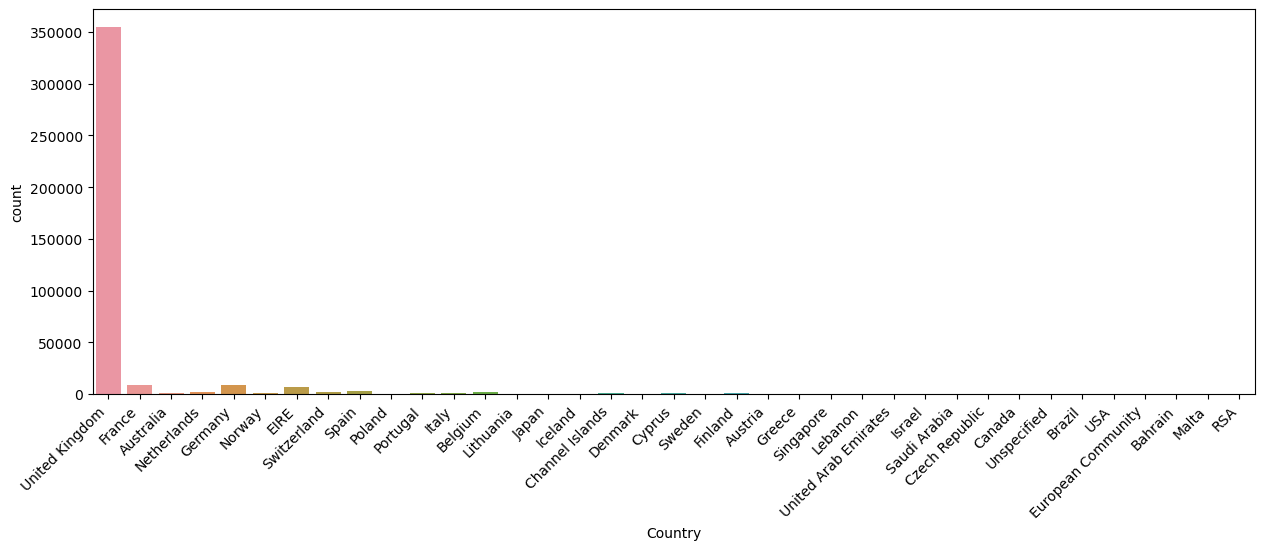

In [9]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        fig_dims = (15, 5)
        fig, ax = plt.subplots(figsize=fig_dims)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.xticks(rotation = 45, ha = 'right')
        plt.show()

cat_summary(df, "Country", plot=True)

### Numerical Variables

In [10]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and col not in "Customer ID"]
num_cols

['Quantity', 'InvoiceDate', 'Price']

count    397925.000000
mean         11.833709
std          25.534486
min           1.000000
5%            1.000000
10%           1.000000
20%           2.000000
30%           2.000000
40%           4.000000
50%           6.000000
60%           8.000000
70%          12.000000
80%          12.000000
90%          24.000000
95%          36.000000
99%         120.000000
max         298.500000
Name: Quantity, dtype: float64


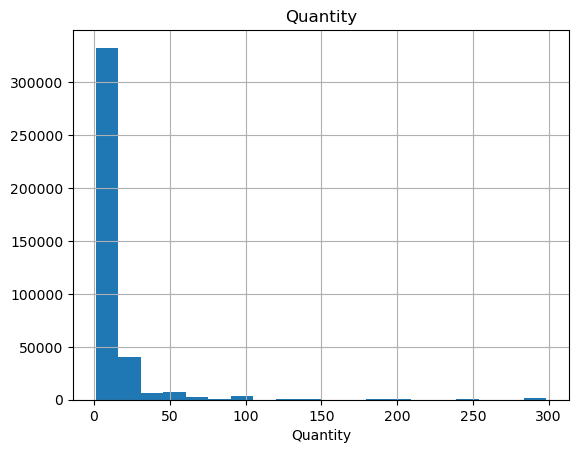

count                  397925
unique                  17286
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object


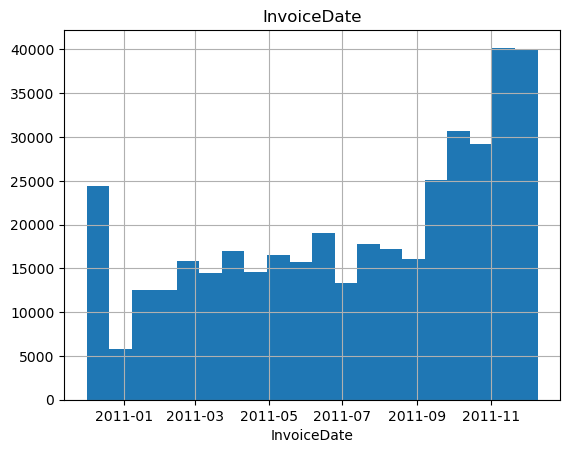

count    397925.000000
mean          2.893201
std           3.227143
min           0.000000
5%            0.420000
10%           0.550000
20%           0.850000
30%           1.250000
40%           1.650000
50%           1.950000
60%           2.100000
70%           2.950000
80%           4.150000
90%           6.350000
95%           8.500000
99%          14.950000
max          37.060000
Name: Price, dtype: float64


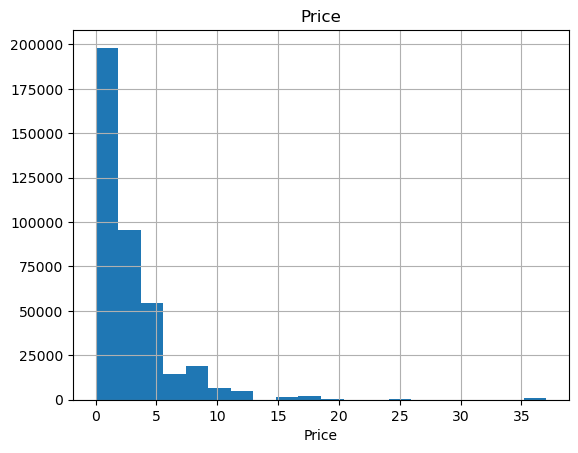

In [11]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

In [12]:
# unique product
df["StockCode"].nunique()

3665

In [13]:
# How many sales for each product?
df_product = df.groupby("Description").agg({"Quantity":"count"})
df_product.reset_index(inplace=True)
df_product

,Description,Quantity
0,4 PURPLE FLOCK DINNER CANDLES,39
1,50'S CHRISTMAS GIFT BAG LARGE,109
2,DOLLY GIRL BEAKER,138
3,I LOVE LONDON MINI BACKPACK,70
4,I LOVE LONDON MINI RUCKSACK,1
...,...,...
3872,ZINC T-LIGHT HOLDER STARS SMALL,238
3873,ZINC TOP 2 DOOR WOODEN SHELF,9
3874,ZINC WILLIE WINKIE CANDLE STICK,192
3875,ZINC WIRE KITCHEN ORGANISER,12


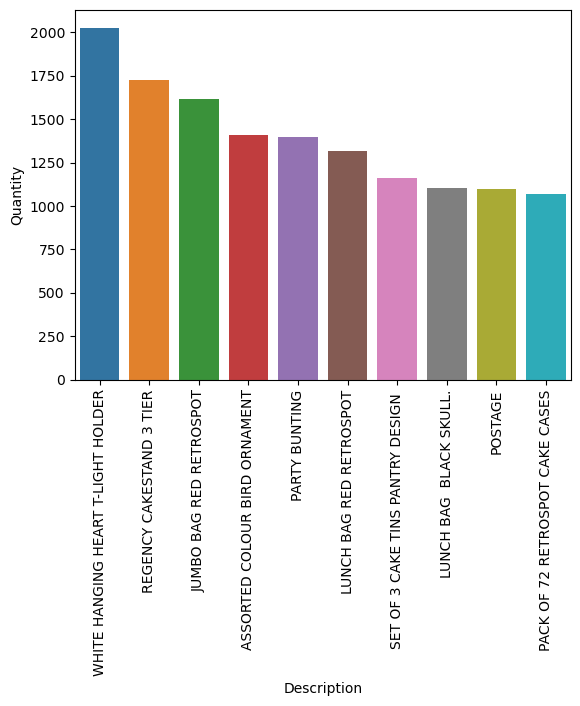

In [14]:
# Top 10 Products
top_pr= df_product.sort_values(by="Quantity",ascending=False).head(10)

sns.barplot(x="Description", y="Quantity", data=top_pr)
plt.xticks(rotation=90)
plt.show()

In [15]:
# total price per invoice
df["TotalPrice"] = df["Price"] * df["Quantity"]

## Customer Segmentation With RFM

In [16]:
# Determining the analysis date for the recency
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)

In [17]:
# Generating RFM metrics
rfm = df.groupby("Customer ID").agg({"InvoiceDate": lambda InvıiceDate: (today_date- InvıiceDate.max()).days,
                                    "Invoice": lambda Invoice: Invoice.nunique(),
                                    "TotalPrice": lambda TotalPrice: TotalPrice.sum()})

rfm.columns = ["recency","frequency","monetary"]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4339.0,93.041484,100.007757,1.0,18.000,51.00,142.500,374.000
frequency,4339.0,4.271952,7.705493,1.0,1.000,2.00,5.000,210.000
monetary,4339.0,1891.748117,7705.372078,0.0,303.125,662.59,1630.445,266163.525


In [18]:
# monetary, the min value of the total money paid can't be 0
# let's remove them from the data

rfm = rfm[rfm["monetary"] > 0]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0,93.059474,100.012264,1.00,18.0000,51.0,142.7500,374.000
frequency,4338.0,4.272706,7.706221,1.00,1.0000,2.0,5.0000,210.000
monetary,4338.0,1892.184204,7706.206805,3.75,303.3075,663.1,1631.1075,266163.525


### Generating RFM Scores

In [19]:
# recency_score
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
# frequency_score
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
# monetary_score
rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels=[1, 2, 3, 4, 5])

#  RFM Score
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str))
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.0,326,1,310.44,1,1,2,11
12347.0,3,7,4310.00,5,5,5,55
12348.0,76,4,1770.78,2,4,4,24
12349.0,19,1,1491.72,4,1,4,41
12350.0,311,1,331.46,1,1,2,11
12352.0,37,8,1756.34,3,5,4,35
12353.0,205,1,89.00,1,1,1,11
12354.0,233,1,1079.40,1,1,4,11
12355.0,215,1,459.40,1,1,2,11


## Segmenting Customers Based on RFM Scores

In [20]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
12346.0,326,1,310.44,1,1,2,11,hibernating
12347.0,3,7,4310.00,5,5,5,55,champions
12348.0,76,4,1770.78,2,4,4,24,at_Risk
12349.0,19,1,1491.72,4,1,4,41,promising
12350.0,311,1,331.46,1,1,2,11,hibernating
12352.0,37,8,1756.34,3,5,4,35,loyal_customers
12353.0,205,1,89.00,1,1,1,11,hibernating
12354.0,233,1,1079.40,1,1,4,11,hibernating
12355.0,215,1,459.40,1,1,2,11,hibernating


In [21]:
# Let's group RFM mean and frequency values according to segments
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency        frequency           monetary      
                           mean count       mean count         mean count
segment                                                                  
about_to_sleep        53.312500   352   1.161932   352   469.058097   352
at_Risk              153.785835   593   2.878583   593   938.458341   593
cant_loose           132.968254    63   8.380952    63  2646.822540    63
champions              6.361769   633  12.417062   633  6498.641414   633
hibernating          217.605042  1071   1.101774  1071   398.573036  1071
loyal_customers       33.608059   819   6.479853   819  2752.519574   819
need_attention        52.427807   187   2.326203   187   847.657086   187
new_customers          7.428571    42   1.000000    42   314.883690    42
potential_loyalists   17.398760   484   2.010331   484   674.628357   484
promising             23.510638    94   1.000000    94   285.623723    94

## Visualization of RFM Segments

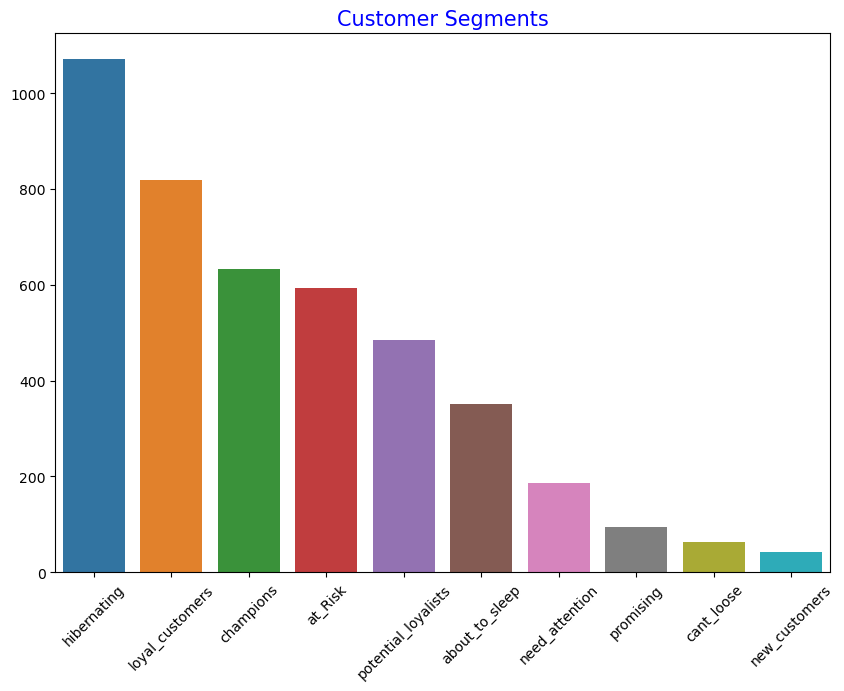

In [22]:
sgm= rfm["segment"].value_counts()
plt.figure(figsize=(10,7))
sns.barplot(x=sgm.index,y=sgm.values)
plt.xticks(rotation=45)
plt.title('Customer Segments',color = 'blue',fontsize=15)
plt.show()

In [23]:
# Treemap Visualization
df_treemap = rfm.groupby('segment').agg('count').reset_index()
df_treemap.head()

,segment,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,about_to_sleep,352,352,352,352,352,352,352
1,at_Risk,593,593,593,593,593,593,593
2,cant_loose,63,63,63,63,63,63,63
3,champions,633,633,633,633,633,633,633
4,hibernating,1071,1071,1071,1071,1071,1071,1071


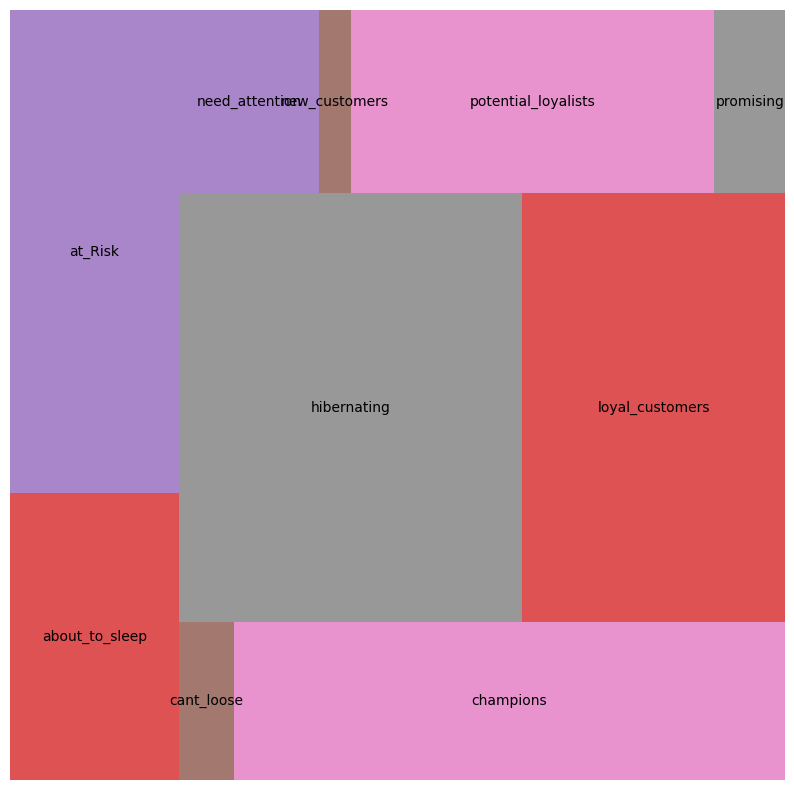

In [24]:
fig, ax = plt.subplots(1, figsize = (10,10))

squarify.plot(sizes=df_treemap['RFM_SCORE'], 
              label=df_treemap['segment'], 
              alpha=.8,
              color=['tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
             )
plt.axis('off')
plt.show()
#plt.savefig('treemap.png')

## Customer Lifetime Value

Customer lifetime value (CLV), a term sometimes used interchangeably with customer lifetime value, is the prediction of a company's net profit contributed to its overall future relationship with a customer. The model can be simple or sophisticated, depending on how complex the predictive analytics techniques are.

Lifetime value is a critical metric because it represents the maximum amount that customers may be expected to spend in order to acquire new ones. As a result, it's crucial in determining the payback of marketing expenses used in marketing mix modeling.

In [25]:
# Determining the analysis date for the recency
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)

In [27]:
cltv_df = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                         lambda date: (today_date - date.min()).days],
                                         'Invoice': lambda num: num.nunique(),
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})


cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,0,326,1,310.44
12347.0,365,368,7,4310.00
12348.0,282,359,4,1770.78
12349.0,0,19,1,1491.72
12350.0,0,311,1,331.46


In [28]:
# monetary değerini toplam totalPrice olarak hesaplamıştık.
# bu aşamada moneary değerini satın alma başına ortalama kazanç olarak ifade edeceğiz
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

# monetary nin sıfırdan büyük olanlarının seçelimesi
cltv_df = cltv_df[cltv_df["monetary"] > 0]

# BGNBD için recency ve T'nin haftalık cinsten ifade edilmesi
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

# frequency nin 1 den büyük olanlarının seçilmesi
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.0,52.142857,52.571429,7,615.714286
12348.0,40.285714,51.285714,4,442.695000
12352.0,37.142857,42.428571,8,219.542500
12356.0,43.142857,46.571429,3,937.143333
12358.0,21.285714,21.571429,2,575.210000


## BG-NBD Model

BG / NBD (Beta Geometric / Negative Binominal Distribution) = Expected Number of Transaction

In [29]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

In [30]:
# 1 week expected purchase (transaction)
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

cltv_df.sort_values("expected_purc_1_week", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12748.0,53.142857,53.428571,210,154.192429,3.265158
14911.0,53.142857,53.428571,201,691.710100,3.126645
17841.0,53.000000,53.428571,124,330.134355,1.940290
13089.0,52.285714,52.857143,97,606.362474,1.537528
14606.0,53.142857,53.428571,93,130.139032,1.463999
15311.0,53.285714,53.428571,91,667.779121,1.433717
12971.0,52.571429,53.285714,86,127.485872,1.357024
14646.0,50.428571,50.714286,74,3596.804392,1.222517
13408.0,53.000000,53.428571,62,453.500645,0.986249


In [31]:
# 1 month expected purchase
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

cltv_df.sort_values("expected_purc_1_month", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12748.0,53.142857,53.428571,210,154.192429,3.265158,13.025670
14911.0,53.142857,53.428571,201,691.710100,3.126645,12.473095
17841.0,53.000000,53.428571,124,330.134355,1.940290,7.740345
13089.0,52.285714,52.857143,97,606.362474,1.537528,6.133456
14606.0,53.142857,53.428571,93,130.139032,1.463999,5.840269
15311.0,53.285714,53.428571,91,667.779121,1.433717,5.719467
12971.0,52.571429,53.285714,86,127.485872,1.357024,5.413481
14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360
13408.0,53.000000,53.428571,62,453.500645,0.986249,3.934373


### Gamma Gamma Model

It is used to estimate how much profit a customer can generate on average per transaction.

#### What will the gamma gamma model do?

It will output the Expected Average Profit. This means; The Expected Average Profit distribution will be modeled over the whole audience, and the Gamma Gamma Submodel will be conditionally giving us the Expected Average Profit for a person, taking into account the distribution of the whole audience, according to the characteristics of the person himself.

In [32]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [33]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

cltv_df.sort_values("expected_average_profit", ascending=False).head(20)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
Customer ID,,,,,,,
12415.0,44.714286,48.285714,21,5724.302619,0.379618,1.513975,5772.177190
12590.0,0.000000,30.285714,2,4591.172500,0.011536,0.045934,5029.409866
12435.0,26.857143,38.285714,2,3914.945000,0.076313,0.304072,4288.935706
12409.0,14.714286,26.142857,3,3690.890000,0.117435,0.467406,3918.807905
14088.0,44.571429,46.142857,13,3864.554615,0.260297,1.037956,3917.128640
18102.0,52.285714,52.571429,60,3859.739083,0.968607,3.863856,3870.996702
12753.0,48.428571,51.857143,6,3571.565000,0.126058,0.502765,3678.576111
14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360,3605.309159
15749.0,13.857143,47.571429,3,3028.780000,0.027979,0.111556,3216.048315


## BG-NBD and GG Model For Prediction

In [34]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [35]:
# Reset index
cltv = cltv.reset_index()
# Merging the main table and the forecast values table
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
# sorting
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360,3605.309159,108691.798098
2761,18102.0,52.285714,52.571429,60,3859.739083,0.968607,3.863856,3870.996702,92510.277867
843,14096.0,13.857143,14.571429,17,3163.588235,0.728797,2.895990,3196.435385,56135.700476
36,12415.0,44.714286,48.285714,21,5724.302619,0.379618,1.513975,5772.177190,53978.799538
1257,14911.0,53.142857,53.428571,201,691.710100,3.126645,12.473095,692.326355,53427.083098
2458,17450.0,51.285714,52.571429,46,2863.274891,0.747475,2.981719,2874.198462,53004.426828
874,14156.0,51.571429,53.142857,55,2104.026727,0.877551,3.500701,2110.754090,45708.064488
2487,17511.0,52.857143,53.428571,31,2933.943065,0.508850,2.029876,2950.579794,37047.560382
2075,16684.0,50.428571,51.285714,28,2209.969107,0.478081,1.906950,2223.884691,26217.823311
650,13694.0,52.714286,53.428571,50,1275.700500,0.800854,3.194773,1280.218167,25301.558174


In [36]:
# 1 Month CLTV:
cltv_1 = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=1,  # 1 month
                                   freq="W",  # frequency of T
                                   discount_rate=0.01)

cltv_1.head()
cltv_1= cltv_1.reset_index()
cltv_1 = cltv_df.merge(cltv_1, on="Customer ID", how="left")
cltv_1.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360,3605.309159,18902.050248
2761,18102.0,52.285714,52.571429,60,3859.739083,0.968607,3.863856,3870.996702,16081.184785
843,14096.0,13.857143,14.571429,17,3163.588235,0.728797,2.895990,3196.435385,9948.435203
36,12415.0,44.714286,48.285714,21,5724.302619,0.379618,1.513975,5772.177190,9395.535477
1257,14911.0,53.142857,53.428571,201,691.710100,3.126645,12.473095,692.326355,9284.571962
2458,17450.0,51.285714,52.571429,46,2863.274891,0.747475,2.981719,2874.198462,9214.194426
874,14156.0,51.571429,53.142857,55,2104.026727,0.877551,3.500701,2110.754090,7944.525063
2487,17511.0,52.857143,53.428571,31,2933.943065,0.508850,2.029876,2950.579794,6439.495406
2075,16684.0,50.428571,51.285714,28,2209.969107,0.478081,1.906950,2223.884691,4559.551262
1754,16000.0,0.000000,0.428571,3,2335.120000,0.422126,1.664397,2479.801743,4432.241509


In [37]:
# 12 Month CLTV Forecast:

cltv_12 = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=12,  # 1 aylık
                                   freq="W",  # T'nin frekans bilgisi
                                   discount_rate=0.01)

cltv_12.head()
cltv_12 = cltv_12.reset_index()
cltv_12 = cltv_df.merge(cltv_12, on="Customer ID", how="left")
cltv_12.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360,3605.309159,207476.975621
2761,18102.0,52.285714,52.571429,60,3859.739083,0.968607,3.863856,3870.996702,176649.342133
843,14096.0,13.857143,14.571429,17,3163.588235,0.728797,2.895990,3196.435385,105762.291340
36,12415.0,44.714286,48.285714,21,5724.302619,0.379618,1.513975,5772.177190,102964.326961
1257,14911.0,53.142857,53.428571,201,691.710100,3.126645,12.473095,692.326355,102044.017958
2458,17450.0,51.285714,52.571429,46,2863.274891,0.747475,2.981719,2874.198462,101209.239811
874,14156.0,51.571429,53.142857,55,2104.026727,0.877551,3.500701,2110.754090,87288.675475
2487,17511.0,52.857143,53.428571,31,2933.943065,0.508850,2.029876,2950.579794,70747.402561
2075,16684.0,50.428571,51.285714,28,2209.969107,0.478081,1.906950,2223.884691,50044.760217
650,13694.0,52.714286,53.428571,50,1275.700500,0.800854,3.194773,1280.218167,48320.424555


## Segmentation on CLTV Forecasts

In [38]:
# Normalization 0-1 Range For CLV Values
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])

cltv_final.sort_values(by="scaled_clv", ascending=False).head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,scaled_clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.222517,4.876360,3605.309159,108691.798098,1.000000
2761,18102.0,52.285714,52.571429,60,3859.739083,0.968607,3.863856,3870.996702,92510.277867,0.851125
843,14096.0,13.857143,14.571429,17,3163.588235,0.728797,2.895990,3196.435385,56135.700476,0.516467
36,12415.0,44.714286,48.285714,21,5724.302619,0.379618,1.513975,5772.177190,53978.799538,0.496623
1257,14911.0,53.142857,53.428571,201,691.710100,3.126645,12.473095,692.326355,53427.083098,0.491547


In [39]:
# Segmentation of Customers
cltv_final["segment"] = pd.qcut(cltv_final["scaled_clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.head()

cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,scaled_clv,segment
0,12347.0,52.142857,52.571429,7,615.714286,0.141283,0.563516,631.911974,2200.757918,0.020248,A
1,12348.0,40.285714,51.285714,4,442.695000,0.091963,0.366752,463.745539,1050.352322,0.009664,B
2,12352.0,37.142857,42.428571,8,219.542500,0.182395,0.727126,224.886669,1007.740746,0.009272,B
3,12356.0,43.142857,46.571429,3,937.143333,0.086160,0.343511,995.997679,2109.557904,0.019409,A
4,12358.0,21.285714,21.571429,2,575.210000,0.122258,0.486232,631.900951,1870.555107,0.017210,A


In [40]:
# Examination of Segments
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

Customer ID                           recency                   \
                sum count          mean           sum count       mean   
segment                                                                  
D        11073488.0   712  15552.651685  15705.142857   712  22.057785   
C        10895576.0   711  15324.298172  21747.142857   711  30.586699   
B        10910905.0   711  15345.857947  20974.142857   711  29.499498   
A        10626242.0   711  14945.488045  22414.428571   711  31.525216   

                    T                  frequency  ... expected_purc_1_month  \
                  sum count       mean       sum  ...                  mean   
segment                                           ...                         
D        28780.285714   712  40.421750      2183  ...              0.283548   
C        27054.428571   711  38.051236      2909  ...              0.480978   
B        24746.428571   711  34.805103      3856  ...              0.645186   
A        24596.142857   711  34.593731      8094  ...              1.089390   

        expected_average_profit                             clv        \
                            sum count        mean           sum count   
segment                                                                 
D                 141735.786739   712  199.067116  1.983117e+05   712   
C                 206064.393038   711  289.823338  5.261275e+05   711   
B                 280456.503624   711  394.453592  9.498650e+05   711   
A                 487558.495359   711  685.736280  3.069753e+06   711   

                     scaled_clv                  
                mean        sum count      mean  
segment                                          
D         278.527637   1.824532   712  0.002563  
C         739.982459   4.840545   711  0.006808  
B        1335.956469   8.739068   711  0.012291  
A        4317.514602  28.242728   711  0.039723  

[4 rows x 30 columns]